In [1]:
import numpy as np
import pandas as pd
import torch
import random
import copy
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
dquery = np.load("synthetic_query_v1.npy").astype(np.float32)
dtest = np.load("synthetic_test_v1.npy").astype(np.float32)
dcf = np.load("64/synthetic-plaincf.npy").astype(np.float32)
dccf = np.load("64/synthetic-plaincf-2.npy").astype(np.float32)

In [3]:
query_x, query_y = dquery[:, 0:2], dquery[:, 2:3]
test_x, test_y = dtest[:, 0:2], dtest[:, 2:3]
cf_x, cf_y = dcf[:, 0:2], dcf[:, 2:3]
ccf_x, ccf_y = dccf[:, 0:2], dccf[:, 2:3]

In [4]:
scaler = MinMaxScaler()
query_x = scaler.fit_transform(query_x)
test_x = scaler.transform(test_x)
cf_x = scaler.transform(cf_x)
ccf_x = scaler.transform(ccf_x)

In [5]:
h= 0.02
x_min, x_max = dquery[:, 0].min() - .5, dquery[:, 0].max() + .5
y_min, y_max = dquery[:, 1].min() - .5, dquery[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                 np.arange(y_min, y_max, h))

dplot = np.c_[xx.ravel(), yy.ravel()]
_dplot = scaler.transform(dplot).astype(np.float32)
_dplot = torch.from_numpy(_dplot)

In [6]:
test_x = torch.from_numpy(test_x)
test_y = torch.from_numpy(test_y)

In [55]:
idx1 = [15,]
query_sx, query_sy = query_x[idx1], query_y[idx1]
cf_sx, cf_sy = cf_x[idx1], cf_y[idx1]

train_x, train_y = np.concatenate((query_sx, cf_sx), axis = 0), np.concatenate((query_sy, cf_sy), axis = 0)

In [56]:
Query = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))

In [57]:
query_loader = DataLoader(Query, batch_size  = 32)

In [58]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    model.train()
    prediction = []
    label = []

    for batch_idx, (data, target) in enumerate(iterator):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        preds = torch.round(output)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * len(target)
        label.extend(target.tolist())
        prediction.extend(preds.reshape(-1).tolist())

    acc = accuracy_score(label, prediction)
    f1 = f1_score(label, prediction)

    return epoch_loss / len(iterator.dataset), acc, f1

def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    model.eval()
    prediction = []
    label = []

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(iterator):

            data, target = data.to(device), target.to(device)
            output = model(data)
            _, preds = torch.max(output, 1)
            preds = torch.round(output)
            loss = criterion(output, target)
            epoch_loss += loss.item() * len(target)
            label.extend(target.tolist())
            prediction.extend(preds.reshape(-1).tolist())
            
    acc = accuracy_score(label, prediction)
    f1 = f1_score(label, prediction)

    return epoch_loss / len(iterator.dataset), acc, f1

In [59]:
model1 = nn.Sequential(
    nn.Linear(2, 10),
    nn.ReLU(),
    nn.Linear(10, 1),
    nn.Sigmoid(),
)


optimizer = optim.Adam(model1.parameters(), lr = 0.002)
criterion = nn.BCELoss()
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
model1 = model1.to(device)
criterion = criterion.to(device)

best_f1 = -float('inf')
best_model = None
best_acc = -float('inf')

for epoch in range(1000):

    train_loss, train_acc, train_f1 = train(model1, query_loader, optimizer, criterion, device)
    
    if epoch % 50 == 0:
        print(f'Epoch: {epoch} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Train F1: {train_f1:.4f}')

Epoch: 0 | Train Loss: 0.7179 | Train Acc: 0.5000 | Train F1: 0.6667
Epoch: 50 | Train Loss: 0.6928 | Train Acc: 0.5000 | Train F1: 0.6667
Epoch: 100 | Train Loss: 0.6654 | Train Acc: 1.0000 | Train F1: 1.0000
Epoch: 150 | Train Loss: 0.6248 | Train Acc: 1.0000 | Train F1: 1.0000
Epoch: 200 | Train Loss: 0.5694 | Train Acc: 1.0000 | Train F1: 1.0000
Epoch: 250 | Train Loss: 0.5023 | Train Acc: 1.0000 | Train F1: 1.0000
Epoch: 300 | Train Loss: 0.4272 | Train Acc: 1.0000 | Train F1: 1.0000
Epoch: 350 | Train Loss: 0.3503 | Train Acc: 1.0000 | Train F1: 1.0000
Epoch: 400 | Train Loss: 0.2792 | Train Acc: 1.0000 | Train F1: 1.0000
Epoch: 450 | Train Loss: 0.2190 | Train Acc: 1.0000 | Train F1: 1.0000
Epoch: 500 | Train Loss: 0.1709 | Train Acc: 1.0000 | Train F1: 1.0000
Epoch: 550 | Train Loss: 0.1337 | Train Acc: 1.0000 | Train F1: 1.0000
Epoch: 600 | Train Loss: 0.1054 | Train Acc: 1.0000 | Train F1: 1.0000
Epoch: 650 | Train Loss: 0.0841 | Train Acc: 1.0000 | Train F1: 1.0000
Epoch: 70

In [60]:
test_pred = torch.round(model1(test_x))
agree1 = (test_pred == test_y).sum().float() / test_x.shape[0]
agree1 = agree1.item()
S1 = torch.round(model1(_dplot)).detach().numpy()
S1 = S1.reshape(xx.shape)

In [13]:
print(agree1)

0.7586666941642761


In [14]:
idx2 = [13,]
query_sx, query_sy = query_x[idx2], query_y[idx2]
cf_sx, cf_sy = cf_x[idx2], cf_y[idx2]

train_x, train_y = np.concatenate((query_sx, cf_sx), axis = 0), np.concatenate((query_sy, cf_sy), axis = 0)

In [15]:
print(query_y[idx2], cf_y[idx2])

[[0.]] [[1.]]


In [16]:
Query = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))

In [17]:
query_loader = DataLoader(Query, batch_size  = 32)

In [18]:
model2 = nn.Sequential(
    nn.Linear(2, 10),
    nn.ReLU(),
    nn.Linear(10, 1),
    nn.Sigmoid(),
)


optimizer = optim.Adam(model2.parameters(), lr = 0.001)
criterion = nn.BCELoss()
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
model2 = model2.to(device)
criterion = criterion.to(device)

best_f1 = -float('inf')
best_model = None
best_acc = -float('inf')

for epoch in range(1000):

    train_loss, train_acc, train_f1 = train(model2, query_loader, optimizer, criterion, device)
    
    if epoch % 50 == 0:
        print(f'Epoch: {epoch} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Train F1: {train_f1:.4f}')

Epoch: 0 | Train Loss: 0.7004 | Train Acc: 0.5000 | Train F1: 0.6667
Epoch: 50 | Train Loss: 0.6852 | Train Acc: 0.5000 | Train F1: 0.6667
Epoch: 100 | Train Loss: 0.6742 | Train Acc: 0.5000 | Train F1: 0.6667
Epoch: 150 | Train Loss: 0.6638 | Train Acc: 0.5000 | Train F1: 0.6667
Epoch: 200 | Train Loss: 0.6525 | Train Acc: 0.5000 | Train F1: 0.6667
Epoch: 250 | Train Loss: 0.6394 | Train Acc: 1.0000 | Train F1: 1.0000
Epoch: 300 | Train Loss: 0.6242 | Train Acc: 1.0000 | Train F1: 1.0000
Epoch: 350 | Train Loss: 0.6061 | Train Acc: 1.0000 | Train F1: 1.0000
Epoch: 400 | Train Loss: 0.5850 | Train Acc: 1.0000 | Train F1: 1.0000
Epoch: 450 | Train Loss: 0.5609 | Train Acc: 1.0000 | Train F1: 1.0000
Epoch: 500 | Train Loss: 0.5343 | Train Acc: 1.0000 | Train F1: 1.0000
Epoch: 550 | Train Loss: 0.5059 | Train Acc: 1.0000 | Train F1: 1.0000
Epoch: 600 | Train Loss: 0.4764 | Train Acc: 1.0000 | Train F1: 1.0000
Epoch: 650 | Train Loss: 0.4465 | Train Acc: 1.0000 | Train F1: 1.0000
Epoch: 70

In [19]:
test_pred = torch.round(model2(test_x))
agree2 = (test_pred == test_y).sum().float() / test_x.shape[0]
agree2 = agree2.item()
S2 = torch.round(model2(_dplot)).detach().numpy()
SS2 = S2.reshape(xx.shape)

In [20]:
idx3 = [15, 2, 13, 0, 3, 4, 5, 6, 20]
query_sx, query_sy = query_x[idx3], query_y[idx3]
cf_sx, cf_sy = cf_x[idx3], cf_y[idx3]

train_x, train_y = np.concatenate((query_sx, cf_sx), axis = 0), np.concatenate((query_sy, cf_sy), axis = 0)

In [21]:
Query = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))

In [22]:
query_loader = DataLoader(Query, batch_size  = 32)

In [23]:
model3 = nn.Sequential(
    nn.Linear(2, 10),
    nn.ReLU(),
    nn.Linear(10, 1),
    nn.Sigmoid(),
)


optimizer = optim.Adam(model3.parameters(), lr = 0.001)
criterion = nn.BCELoss()
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
model3 = model3.to(device)
criterion = criterion.to(device)

best_f1 = -float('inf')
best_model = None
best_acc = -float('inf')

for epoch in range(1000):

    train_loss, train_acc, train_f1 = train(model3, query_loader, optimizer, criterion, device)
    
    if epoch % 50 == 0:
        print(f'Epoch: {epoch} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Train F1: {train_f1:.4f}')

Epoch: 0 | Train Loss: 0.6743 | Train Acc: 0.5000 | Train F1: 0.6667
Epoch: 50 | Train Loss: 0.6532 | Train Acc: 1.0000 | Train F1: 1.0000
Epoch: 100 | Train Loss: 0.6270 | Train Acc: 1.0000 | Train F1: 1.0000
Epoch: 150 | Train Loss: 0.5985 | Train Acc: 1.0000 | Train F1: 1.0000
Epoch: 200 | Train Loss: 0.5678 | Train Acc: 1.0000 | Train F1: 1.0000
Epoch: 250 | Train Loss: 0.5360 | Train Acc: 1.0000 | Train F1: 1.0000
Epoch: 300 | Train Loss: 0.5056 | Train Acc: 1.0000 | Train F1: 1.0000
Epoch: 350 | Train Loss: 0.4772 | Train Acc: 1.0000 | Train F1: 1.0000
Epoch: 400 | Train Loss: 0.4513 | Train Acc: 1.0000 | Train F1: 1.0000
Epoch: 450 | Train Loss: 0.4274 | Train Acc: 1.0000 | Train F1: 1.0000
Epoch: 500 | Train Loss: 0.4051 | Train Acc: 1.0000 | Train F1: 1.0000
Epoch: 550 | Train Loss: 0.3842 | Train Acc: 1.0000 | Train F1: 1.0000
Epoch: 600 | Train Loss: 0.3642 | Train Acc: 1.0000 | Train F1: 1.0000
Epoch: 650 | Train Loss: 0.3449 | Train Acc: 1.0000 | Train F1: 1.0000
Epoch: 70

In [24]:
test_pred = torch.round(model3(test_x))
agree3 = (test_pred == test_y).sum().float() / test_x.shape[0]
agree3 = agree3.item()
S3 = torch.round(model3(_dplot)).detach().numpy()
SS3 = S3.reshape(xx.shape)

In [174]:
idx4 = [13,]
cf_sx, cf_sy = cf_x[idx4], cf_y[idx4]
ccf_sx, ccf_sy = ccf_x[idx4], ccf_y[idx4]

train_x, train_y = np.concatenate((cf_sx, ccf_sx), axis = 0), np.concatenate((cf_sy, ccf_sy), axis = 0)

In [175]:
Query = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
query_loader = DataLoader(Query, batch_size  = 32)

In [204]:
model4 = nn.Sequential(
    nn.Linear(2, 10),
    nn.ReLU(),
    nn.Linear(10, 1),
    nn.Sigmoid(),
)


optimizer = optim.Adam(model4.parameters(), lr = 0.003)
criterion = nn.BCELoss()
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
model4 = model4.to(device)
criterion = criterion.to(device)

best_f1 = -float('inf')
best_model = None
best_acc = -float('inf')

for epoch in range(500):

    train_loss, train_acc, train_f1 = train(model4, query_loader, optimizer, criterion, device)
    
    if epoch % 50 == 0:
        print(f'Epoch: {epoch} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Train F1: {train_f1:.4f}')

Epoch: 0 | Train Loss: 0.7011 | Train Acc: 0.5000 | Train F1: 0.6667
Epoch: 50 | Train Loss: 0.6845 | Train Acc: 1.0000 | Train F1: 1.0000
Epoch: 100 | Train Loss: 0.6761 | Train Acc: 1.0000 | Train F1: 1.0000
Epoch: 150 | Train Loss: 0.6603 | Train Acc: 1.0000 | Train F1: 1.0000
Epoch: 200 | Train Loss: 0.6349 | Train Acc: 1.0000 | Train F1: 1.0000
Epoch: 250 | Train Loss: 0.5988 | Train Acc: 1.0000 | Train F1: 1.0000
Epoch: 300 | Train Loss: 0.5538 | Train Acc: 1.0000 | Train F1: 1.0000
Epoch: 350 | Train Loss: 0.5028 | Train Acc: 1.0000 | Train F1: 1.0000
Epoch: 400 | Train Loss: 0.4489 | Train Acc: 1.0000 | Train F1: 1.0000
Epoch: 450 | Train Loss: 0.3951 | Train Acc: 1.0000 | Train F1: 1.0000


In [205]:
test_pred = torch.round(model4(test_x))
agree4 = (test_pred == test_y).sum().float() / test_x.shape[0]
agree4 = agree4.item()
S4 = torch.round(model4(_dplot)).detach().numpy()
SS4 = S4.reshape(xx.shape)

In [206]:
print(agree1, agree2, agree3, agree4)

0.7746666669845581 0.8653333187103271 0.9426666498184204 0.9453333616256714


In [30]:
sample_positive = np.load("sample_positive.npy")
sample_negative = np.load("sample_negative.npy")

In [31]:
model = torch.load("synthetic.pt")
S = model(_dplot).detach().numpy()
S = S.reshape(xx.shape)
SS = S.round()

In [104]:
plt.rcParams['xtick.labelsize']= 17
plt.rcParams['ytick.labelsize']= 17
plt.rcParams["figure.figsize"] = (20, 5)
from collections import OrderedDict
linestyles_dict = OrderedDict(
    [('solid',               (0, ())),
     ('loosely dotted',      (0, (1, 10))),
     ('dotted',              (0, (1, 5))),
     ('densely dotted',      (0, (1, 1))),

     ('loosely dashed',      (0, (5, 10))),
     ('dashed',              (0, (5, 5))),
     ('densely dashed',      (0, (5, 1))),

     ('loosely dashdotted',  (0, (3, 10, 1, 10))),
     ('dashdotted',          (0, (3, 5, 1, 5))),
     ('densely dashdotted',  (0, (3, 1, 1, 1))),

     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))])

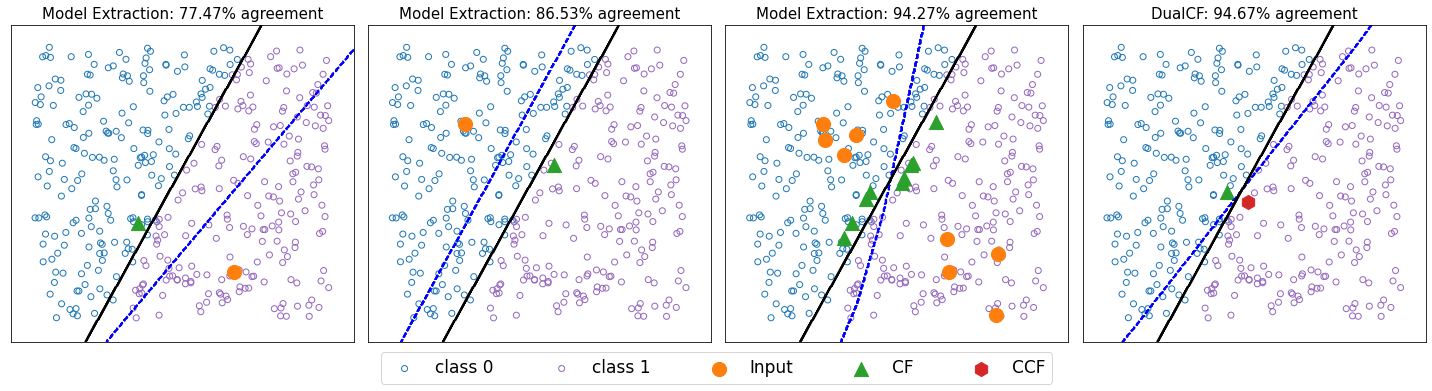

In [135]:
fig, axs = plt.subplots(1, 4)
matplotlib.rcParams['contour.negative_linestyle'] = 'solid'
SS1 = S1.round()
CS1 = axs[0].contour(xx, yy, SS1, colors = "blue", linestyles= 'dashed')
CS2 = axs[1].contour(xx, yy, SS2, colors = "blue", linestyles= 'dashed')
CS3 = axs[2].contour(xx, yy, SS3, colors = "blue", linestyles= 'dashed')
CS4 = axs[3].contour(xx, yy, SS4, colors = "blue", linestyles= 'dashed')
CS = axs[0].contour(xx, yy, SS, colors = 'black')
CS = axs[1].contour(xx, yy, SS, colors = 'black')
CS = axs[2].contour(xx, yy, SS, colors = 'black')
CS = axs[3].contour(xx, yy, SS, colors = 'black')

axs[0].scatter(sample_positive[0:200, 0], sample_positive[0:200, 1], edgecolors = '#1f77b4', label = "class 0", facecolors='none')
axs[0].scatter(sample_negative[0:200, 0], sample_negative[0:200, 1], edgecolors = '#9467bd', label = "class 1", facecolors = 'none')
axs[1].scatter(sample_positive[0:200, 0], sample_positive[0:200, 1], edgecolors = '#1f77b4', label = "class 0", facecolors='none')
axs[1].scatter(sample_negative[0:200, 0], sample_negative[0:200, 1], edgecolors = '#9467bd', label = "class 1", facecolors = 'none')
axs[2].scatter(sample_positive[0:200, 0], sample_positive[0:200, 1], edgecolors = '#1f77b4', label = "class 0", facecolors='none')
axs[2].scatter(sample_negative[0:200, 0], sample_negative[0:200, 1], edgecolors = '#9467bd', label = "class 1", facecolors = 'none')
axs[3].scatter(sample_positive[0:200, 0], sample_positive[0:200, 1], edgecolors = '#1f77b4', label = "class 0", facecolors='none')
axs[3].scatter(sample_negative[0:200, 0], sample_negative[0:200, 1], edgecolors = '#9467bd', label = "class 1", facecolors = 'none')


axs[0].scatter(dquery[idx1, 0], dquery[idx1, 1], s= 200, color = '#ff7f0e', label = "Input")
axs[0].scatter(dcf[idx1, 0], dcf[idx1, 1], marker = "^", s = 200, label = "CF", color = '#2ca02c')

axs[1].scatter(dquery[idx2, 0], dquery[idx2, 1], s= 200, color = '#ff7f0e', label = "Input")
axs[1].scatter(dcf[idx2, 0], dcf[idx2, 1], marker = "^", s = 200, label = "CF", color = '#2ca02c')

axs[2].scatter(dquery[idx3, 0], dquery[idx3, 1], s= 200, color = '#ff7f0e', label = "Input")
axs[2].scatter(dcf[idx3, 0], dcf[idx3, 1], marker = "^", s = 200, label = "CF", color = '#2ca02c')

axs[3].scatter(dcf[idx4, 0], dcf[idx4, 1], marker = "^", s = 200, label = "CF", color = '#2ca02c')
axs[3].scatter(dccf[idx4, 0], dccf[idx4, 1], marker = "h", s = 200, label = "CCF", color = '#d62728')

#axs[0].legend(loc = 'upper right', fontsize = 15, handletextpad = 0, columnspacing = 0, borderpad = 0)
axs[0].set_title("Model Extraction: {:.2f}% agreement".format(agree1 * 100),fontsize = 15)
axs[1].set_title("Model Extraction: {:.2f}% agreement".format(agree2 * 100),fontsize = 15)
axs[2].set_title("Model Extraction: {:.2f}% agreement".format(agree3 * 100),fontsize = 15)
axs[3].set_title("DualCF: {:.2f}% agreement".format(agree4 * 100),fontsize = 15)

axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[3].set_xticks([])
axs[3].set_yticks([])

handles, labels = axs[0].get_legend_handles_labels()
handles1, labels1 = axs[3].get_legend_handles_labels()
handles.append(handles1[-1])
labels.append(labels1[-1])
fig.legend(handles, labels, loc='lower center', ncol = 5, fontsize = 17, columnspacing = 3, bbox_to_anchor = (0.5, -0.1))
plt.tight_layout()
plt.savefig("introduction.pdf", dpi = 600, bbox_inches = 'tight')
plt.show()

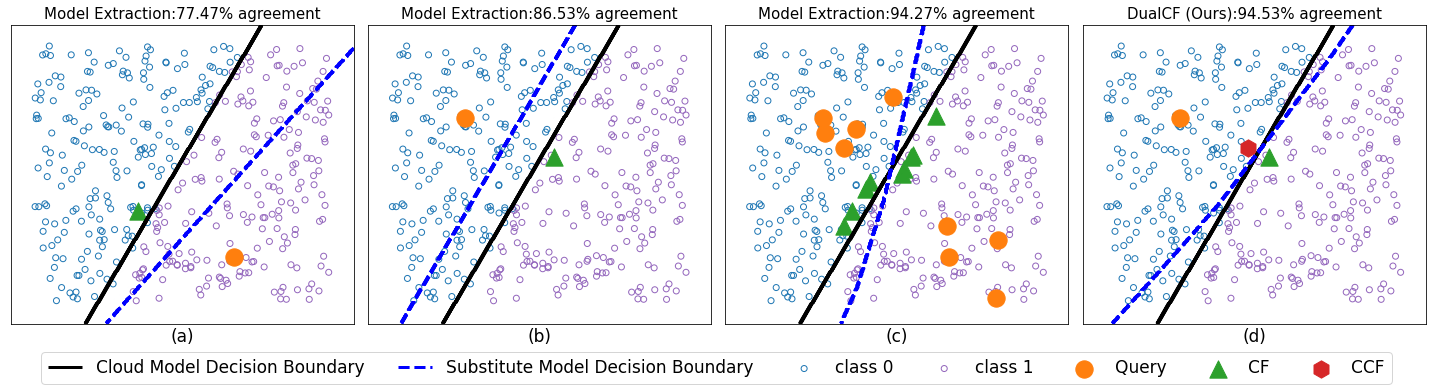

In [210]:
fig, axs = plt.subplots(1, 4)
matplotlib.rcParams['contour.negative_linestyle'] = 'solid'
CS = axs[0].contour(xx, yy, SS, colors = 'black', linewidths=3)
labels = ['Cloud Model Decision Boundary']
for i in range(len(labels)):
    CS.collections[i].set_label(labels[i])
CS = axs[1].contour(xx, yy, SS, colors = 'black', linewidths=3)
CS = axs[2].contour(xx, yy, SS, colors = 'black', linewidths=3)
CS = axs[3].contour(xx, yy, SS, colors = 'black', linewidths=3)

SS1 = S1.round()
CS1 = axs[0].contour(xx, yy, SS1, colors = "blue", linestyles= 'dashed', linewidths=3)
labels = ['Substitute Model Decision Boundary']
for i in range(len(labels)):
    CS1.collections[i].set_label(labels[i])
    
CS2 = axs[1].contour(xx, yy, SS2, colors = "blue", linestyles= 'dashed', linewidths=3)
CS3 = axs[2].contour(xx, yy, SS3, colors = "blue", linestyles= 'dashed', linewidths=3)
CS4 = axs[3].contour(xx, yy, SS4, colors = "blue", linestyles= 'dashed', linewidths=3)


axs[0].scatter(sample_positive[0:200, 0], sample_positive[0:200, 1], edgecolors = '#1f77b4', label = "class 0", facecolors='none')
axs[0].scatter(sample_negative[0:200, 0], sample_negative[0:200, 1], edgecolors = '#9467bd', label = "class 1", facecolors = 'none')
axs[1].scatter(sample_positive[0:200, 0], sample_positive[0:200, 1], edgecolors = '#1f77b4', label = "class 0", facecolors='none')
axs[1].scatter(sample_negative[0:200, 0], sample_negative[0:200, 1], edgecolors = '#9467bd', label = "class 1", facecolors = 'none')
axs[2].scatter(sample_positive[0:200, 0], sample_positive[0:200, 1], edgecolors = '#1f77b4', label = "class 0", facecolors='none')
axs[2].scatter(sample_negative[0:200, 0], sample_negative[0:200, 1], edgecolors = '#9467bd', label = "class 1", facecolors = 'none')
axs[3].scatter(sample_positive[0:200, 0], sample_positive[0:200, 1], edgecolors = '#1f77b4', label = "class 0", facecolors='none')
axs[3].scatter(sample_negative[0:200, 0], sample_negative[0:200, 1], edgecolors = '#9467bd', label = "class 1", facecolors = 'none')


axs[0].scatter(dquery[idx1, 0], dquery[idx1, 1], s= 300, color = '#ff7f0e', label = "Query")
axs[0].scatter(dcf[idx1, 0], dcf[idx1, 1], marker = "^", s = 300, label = "CF", color = '#2ca02c')

axs[1].scatter(dquery[idx2, 0], dquery[idx2, 1], s= 300, color = '#ff7f0e', label = "Query")
axs[1].scatter(dcf[idx2, 0], dcf[idx2, 1], marker = "^", s = 300, label = "CF", color = '#2ca02c')

axs[2].scatter(dquery[idx3, 0], dquery[idx3, 1], s= 300, color = '#ff7f0e', label = "Query")
axs[2].scatter(dcf[idx3, 0], dcf[idx3, 1], marker = "^", s = 300, label = "CF", color = '#2ca02c')

axs[3].scatter(dquery[idx4, 0], dquery[idx4, 1],s = 300, label = "CF", color = '#ff7f0e')
axs[3].scatter(dcf[idx4, 0], dcf[idx4, 1], marker = "^", s = 300, label = "CF", color = '#2ca02c')
axs[3].scatter(dccf[idx4, 0], dccf[idx4, 1], marker = "h", s = 300, label = "CCF", color = '#d62728')

#axs[0].legend(loc = 'upper right', fontsize = 15, handletextpad = 0, columnspacing = 0, borderpad = 0)
axs[0].set_title("Model Extraction:{:.2f}% agreement".format(agree1 * 100),fontsize = 15)
axs[1].set_title("Model Extraction:{:.2f}% agreement".format(agree2 * 100),fontsize = 15)
axs[2].set_title("Model Extraction:{:.2f}% agreement".format(agree3 * 100),fontsize = 15)
axs[3].set_title("DualCF (Ours):{:.2f}% agreement".format(agree4 * 100),fontsize = 15)

axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[3].set_xticks([])
axs[3].set_yticks([])

axs[0].set_xlabel("(a)", fontsize = 17)
axs[1].set_xlabel("(b)", fontsize = 17)
axs[2].set_xlabel("(c)", fontsize = 17)
axs[3].set_xlabel("(d)", fontsize = 17)

handles, labels = axs[0].get_legend_handles_labels()
handles1, labels1 = axs[3].get_legend_handles_labels()
handles.append(handles1[-1])
labels.append(labels1[-1])
fig.legend(handles, labels, loc='lower center', ncol = 7, fontsize = 17, columnspacing = 2, bbox_to_anchor = (0.5, -0.1))
plt.tight_layout()
plt.savefig("introduction_v1.pdf", dpi = 600, bbox_inches = 'tight')
plt.show()

In [86]:
handles1, labels1 = axs[3].get_legend_handles_labels()
print(handles1, labels1)

[<matplotlib.collections.PathCollection object at 0x7f74747ad400>, <matplotlib.collections.PathCollection object at 0x7f74747ad390>, <matplotlib.collections.PathCollection object at 0x7f747c299a58>, <matplotlib.collections.PathCollection object at 0x7f747c299208>] ['class 0', 'class 1', 'CF', 'CCF']


In [90]:
torch.save(model1, "model1.pt")
torch.save(model2, "model2.pt")
torch.save(model3, "model3.pt")
torch.save(model4, "model4.pt")